# Desafio

Utilizando a base de dados "insurance.csv", você tem o desafio de criar um modelo preditivo de regressão para prever o valor dos custos médicos individuais cobrados pelo seguro de saúde.

# Sobre a base de dados

Essa base de dados contém 1338 linhas com informações sobre a idade da pessoa, gênero, índice de massa corporal (IMC), número de filhos, flag de verificação se a possoa é fumante, região residencial do benefício e o valor do custo médico.

# Objetivo

Criar um modelo preditivo e comprovar sua eficácia com métricas estatísticas.

## Importando a base de dados

In [1]:
import pandas as pd

# Importando a base de dados
df = pd.read_csv("insurance.csv")

## Informações da base de dados

In [2]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1338, 7)

* 1338 linhas
* 7 colunas

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


*   Não existe campos vazios
*   3 campos são textos (sex, smoker e region)
*   Os campos sex e smoker são valores binários



## Checando as categorias dos campos tipo texto

In [5]:
set(df['sex'])

{'female', 'male'}

In [6]:
df['sex'].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [7]:
set(df['smoker'])

{'no', 'yes'}

In [8]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [9]:
set(df['region'])

{'northeast', 'northwest', 'southeast', 'southwest'}

In [10]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

## Analisando os dados númericos

In [11]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# Histogramas

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'bmi'}>],
       [<Axes: title={'center': 'children'}>,
        <Axes: title={'center': 'charges'}>]], dtype=object)

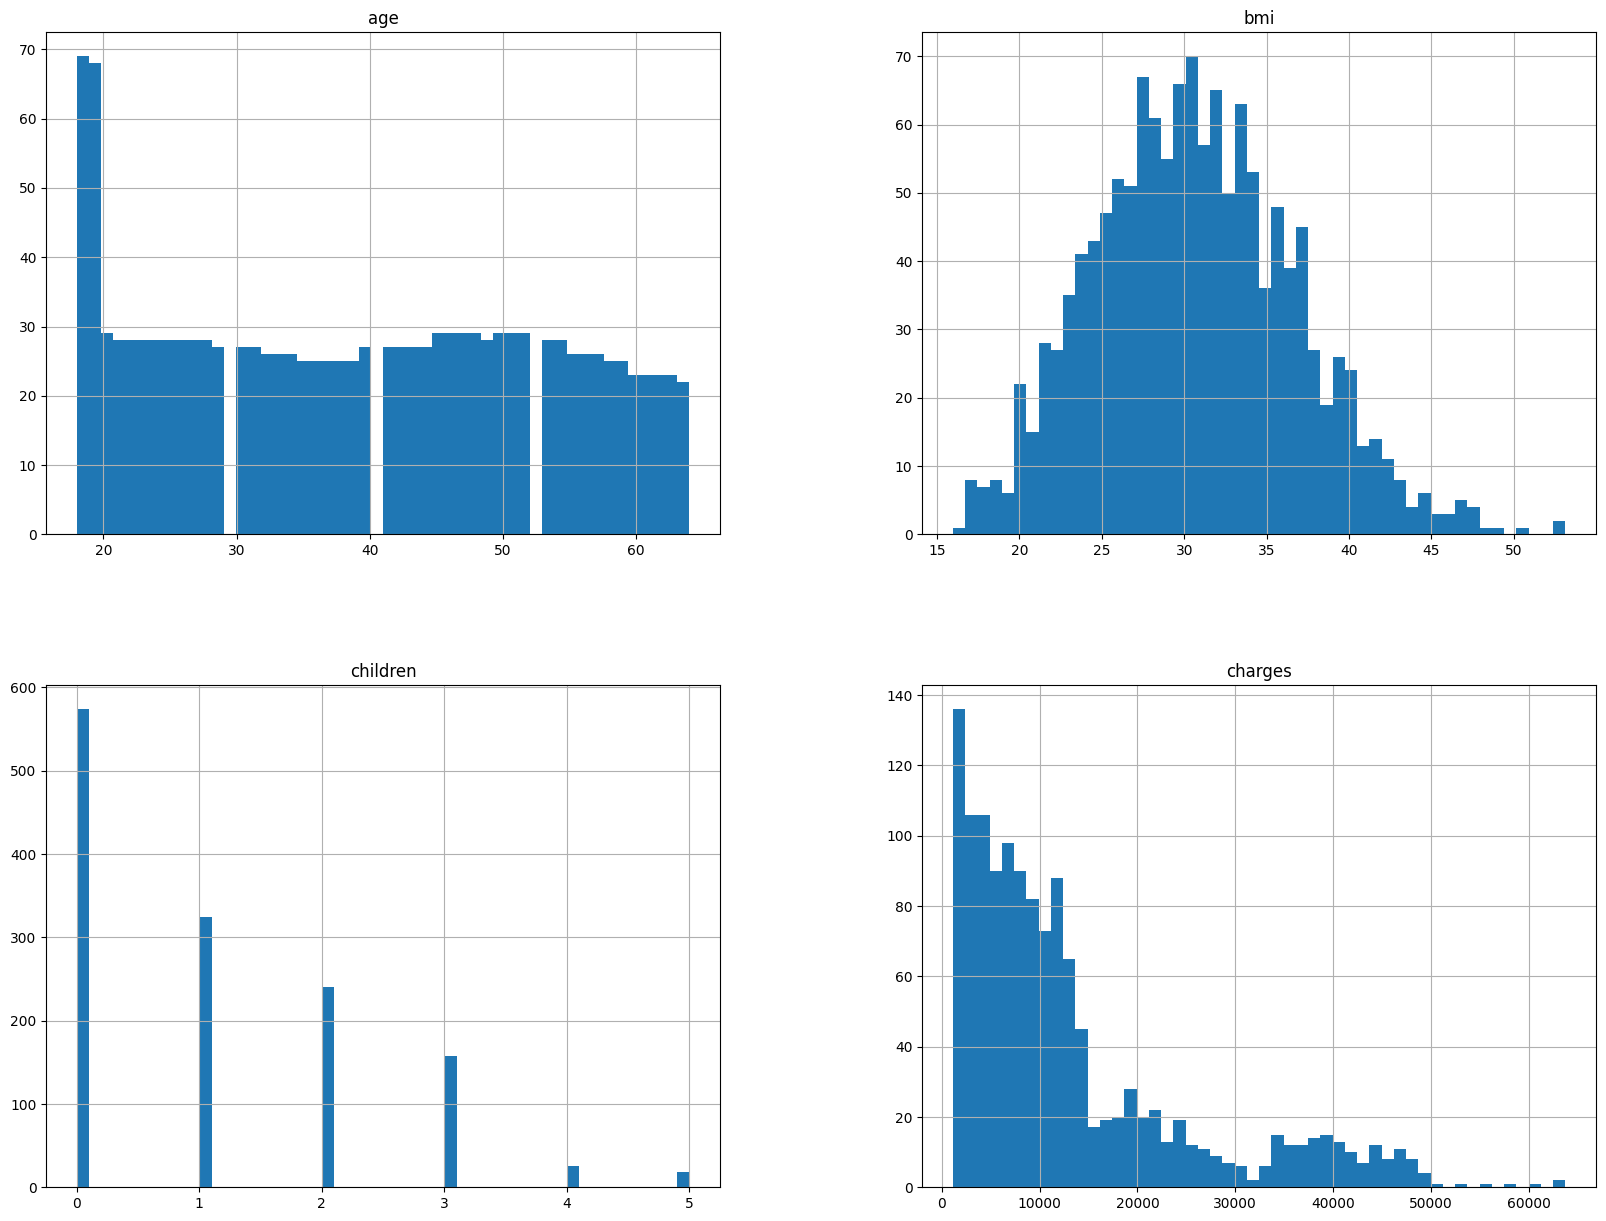

In [12]:
df.hist(bins=50, figsize=(20, 15))

* Existe uma concentração alta de pessoas com menos de 20 anos
* Existe uma concetranção alta de custos médico de até 10 mil
* Alta concentração de pessoas com IMC altos entre as idades de 25 e 35 anos

# Separando as bases em treino e teste

In [13]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.25, random_state=42)
print(len(df_train), "treinamento + ", len(df_test), "teste")

1003 treinamento +  335 teste


## Criando a categoria de custo médico

<Axes: >

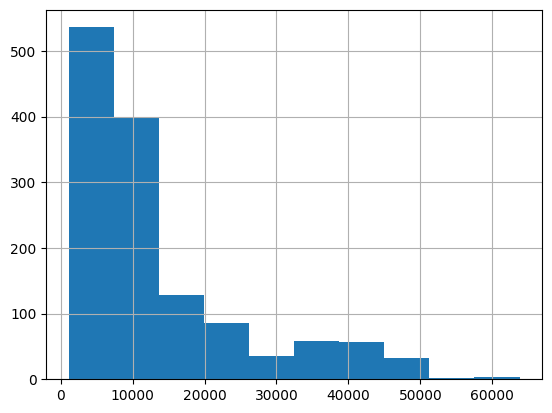

In [14]:
df['charges'].hist()

In [15]:
# Dividindo custos médiso pelo valor 10000 limitar o número de categorias de renda
import numpy as np
np.random.seed(42)

df['charges_cat'] = np.ceil(df['charges'] / 10000.) # ceil para arredondar valores para cima
df['charges_cat'].where(df['charges_cat'] < 5, 5.0, inplace=True)

In [16]:
# cut do Pandas, que é comunente usada para dividir um conjunto de dados em intervalos discretos chamados de "bins" (intervalos ou faixas)
df['charges_cat'] = pd.cut(df['charges'],
       bins=[0., 15000., 30000., 45000., 60000., np.inf],
       labels=[10000, 20000, 30000, 40000, 50000])

In [17]:
df['charges_cat'].value_counts()

charges_cat
10000    980
20000    196
30000    124
40000     35
50000      3
Name: count, dtype: int64

<Axes: >

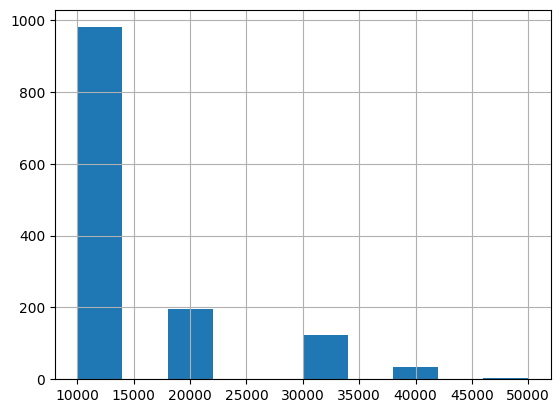

In [18]:
df['charges_cat'].hist()

## Amostragem estratificada com base na categoria de custs médicos

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, test_index in split.split(df, df['charges_cat']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [20]:
# Analisando proporções
strat_test_set['charges_cat'].value_counts() / len(strat_test_set)

charges_cat
10000    0.731343
20000    0.146269
30000    0.092537
40000    0.026866
50000    0.002985
Name: count, dtype: float64

In [21]:
# Analisando proporções
df['charges_cat'].value_counts() / len(df)

charges_cat
10000    0.732436
20000    0.146487
30000    0.092676
40000    0.026158
50000    0.002242
Name: count, dtype: float64

Depois de garantir que os valores dos custos médico estão distribuídos de forma estratificada, podemos remover a coluna charges_cat que foi utilizada como variável auxiliar.

In [22]:
# Removendo a coluna charges_cat
for set_ in (strat_train_set, strat_test_set):
  set_.drop('charges_cat', axis=1, inplace=True)

# Buscando Correlações

In [23]:
charges = strat_train_set.copy()
charges.head()

,age,sex,bmi,children,smoker,region,charges
83,48,female,41.23,4,no,northwest,11033.6617
187,30,female,30.90,3,no,southwest,5325.6510
1316,19,female,20.60,0,no,southwest,1731.6770
679,49,female,23.18,2,no,northwest,10156.7832
801,64,female,35.97,0,no,southeast,14313.8463


In [24]:
charges_matrix = charges.corr(numeric_only=True)

In [25]:
charges_matrix['charges'].sort_values(ascending=False)

charges     1.000000
age         0.304440
bmi         0.195083
children    0.048652
Name: charges, dtype: float64

*   Não considerando os campos sex, smoker e region parece que os dados possuem pouc correlação
* Os campos age e bmi (IMC) possuem maior correlação com os custos médico

array([[<Axes: xlabel='age', ylabel='age'>,
        <Axes: xlabel='bmi', ylabel='age'>,
        <Axes: xlabel='children', ylabel='age'>],
       [<Axes: xlabel='age', ylabel='bmi'>,
        <Axes: xlabel='bmi', ylabel='bmi'>,
        <Axes: xlabel='children', ylabel='bmi'>],
       [<Axes: xlabel='age', ylabel='children'>,
        <Axes: xlabel='bmi', ylabel='children'>,
        <Axes: xlabel='children', ylabel='children'>]], dtype=object)

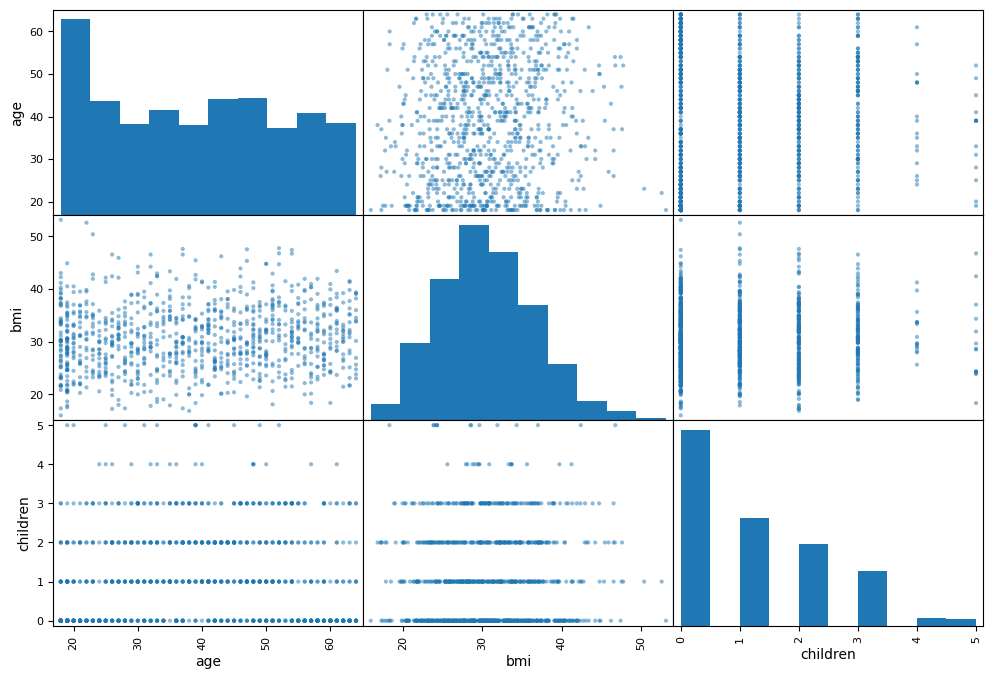

In [26]:
from pandas.plotting import scatter_matrix

attributes = ['age', 'bmi', 'children']
scatter_matrix(charges[attributes], figsize=(12, 8))

*   Parece que a idade (age) possui maior correlação para prever os custos médicos
*   O IMC (bmi) também possui uma forte correlação, porém menor comparado a idade

(0.0, 50000.0, 0.0, 70.0)

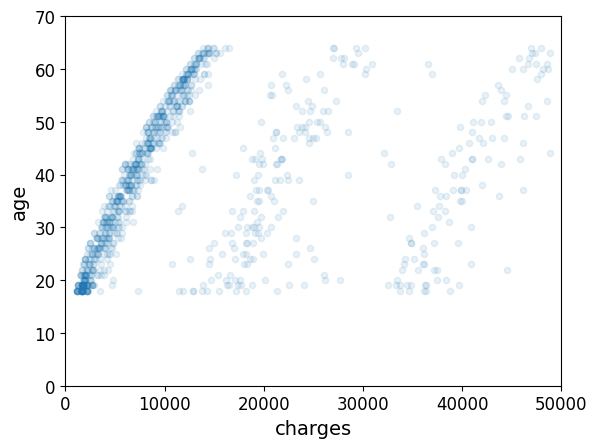

In [27]:
# Para plots bonitinhos
# permite a exibição de gráficos gerados pelo Matplotlib diretamente dentro do notebook ou ambiente de desenvolvimento, sem a necessidade de chamar explicitamente a função plt.show()
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Plotando as colunas charges e age
charges.plot(kind='scatter', x='charges', y='age', alpha=0.1)
plt.axis([0, 50000, 0, 70])

Observações:
*   Quanta mais velha a pessoa maior é o valor de custo médico
*   Maior parte dos custos médicos fica em torno de 10000

# Preparando os dados para colocar no algoritmo

In [48]:
charges = strat_train_set.drop('charges', axis=1) # Apagando a target para a base de treino (X)
charges_labels = strat_train_set['charges'].copy() # Armazenando a target (X)

In [29]:
charges_num = charges.drop(['sex', 'smoker', 'region'], axis=1)
charges_num.head()

,age,bmi,children
83,48,41.23,4
187,30,30.90,3
1316,19,20.60,0
679,49,23.18,2
801,64,35.97,0


# Pré-processando as categorias

Tratando as categorias de textos.

In [30]:
charges_cat_ordinal = charges[['region']]
charges_cat_ordinal.head(10)

,region
83,northwest
187,southwest
1316,southwest
679,northwest
801,southeast
1079,southeast
360,northeast
1085,southwest
346,southeast
118,southeast


In [31]:
charges_cat_bin_sex = charges[['sex']]
charges_cat_bin_sex.head(10)

,sex
83,female
187,female
1316,female
679,female
801,female
1079,male
360,female
1085,female
346,male
118,female


In [32]:
charges_cat_ordinal_smoker = charges[['smoker']]
charges_cat_ordinal_smoker.head(10)

,smoker
83,no
187,no
1316,no
679,no
801,no
1079,no
360,no
1085,yes
346,no
118,no


## Valores Ordinais

In [33]:
try:
  from sklearn.preprocessing import OrdinalEncoder
except:
  from future_encoders import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
charges_cat_region_encoded = ordinal_encoder.fit_transform(charges_cat_ordinal)
charges_cat_region_encoded[:10]

array([[1.],
       [3.],
       [3.],
       [1.],
       [2.],
       [2.],
       [0.],
       [3.],
       [2.],
       [2.]])

In [34]:
ordinal_encoder.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [35]:
ordinal_encoder_smoker = OrdinalEncoder()
charges_cat_smoker_encoded = ordinal_encoder_smoker.fit_transform(charges_cat_ordinal_smoker)
charges_cat_smoker_encoded[:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [36]:
ordinal_encoder_smoker.categories_

[array(['no', 'yes'], dtype=object)]

## Valores binários

In [37]:
try:
  from sklearn.preprocessing import OneHotEncoder
except:
  from future_encoders import OneHotEncoder

cat_encoder_sex = OneHotEncoder(sparse=False)
charges_cat_1hot_bin_sex = cat_encoder_sex.fit_transform(charges_cat_bin_sex)
charges_cat_1hot_bin_sex

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [38]:
cat_encoder_sex.categories_

[array(['female', 'male'], dtype=object)]

# Criando a pipeline de pré-processamento dos dados

Agora vamos construir uma pipeline para pré-processar os atributos numéricos

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # funções que retorna a média e o desvio padrão dos dados

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()), # padronizando as escalas dos dados
])

charges_num_tr = num_pipeline.fit_transform(charges_num)

In [40]:
charges_num_tr

array([[ 0.65475784,  1.73406719,  2.41584621],
       [-0.62679009,  0.04317245,  1.58516615],
       [-1.40995826, -1.64281166, -0.90687405],
       ...,
       [ 0.44116652, -1.68373361,  1.58516615],
       [-1.05397273, -0.47735469, -0.90687405],
       [ 1.01074338, -0.64431622,  0.75448608]])

Agora vamos tratar os valores categóricos

In [41]:
try:
  from sklearn.compose import ColumnTransformer
except:
  from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [42]:
from sklearn.compose import ColumnTransformer

num_attribs = list(charges_num)
cat_attribs_ordinal = ['region']
cat_attribs_bin_sex = ['sex',]
cat_attribs_ordinal_smoker = ['smoker']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs), # tratando as variáveis numéricas (chamada a pipeline de cima)
    ('cat_ordinal', OrdinalEncoder(), cat_attribs_ordinal), # tratando as variáveis categóricas, region
    ('cat_bin_sex', OneHotEncoder(), cat_attribs_bin_sex), # tratando as variáveis categóricas, sex
    ('cat_ordinal_smoker', OrdinalEncoder(), cat_attribs_ordinal_smoker), # tratando as variáveis categóricas, smoker
])

charges_prepared = full_pipeline.fit_transform(charges)

In [43]:
charges_prepared

array([[ 0.65475784,  1.73406719,  2.41584621, ...,  1.        ,
         0.        ,  0.        ],
       [-0.62679009,  0.04317245,  1.58516615, ...,  1.        ,
         0.        ,  0.        ],
       [-1.40995826, -1.64281166, -0.90687405, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.44116652, -1.68373361,  1.58516615, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05397273, -0.47735469, -0.90687405, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.01074338, -0.64431622,  0.75448608, ...,  1.        ,
         0.        ,  0.        ]])

In [44]:
charges_prepared.shape

(1003, 7)

In [45]:
type(charges_prepared)

numpy.ndarray

Perceba que o resultado é uma matriz multidimensional. Precisamos transforma-lá em datarrame.

In [46]:
column_names = ['age', 'bmi', 'children', 'region', 'female', 'male', 'smoker']

# Transformar o array em DataFrame
charges_df = pd.DataFrame(data=charges_prepared, columns=column_names)

# Exibir o DataFrame resultante
print(charges_df.shape)

(1003, 7)


In [47]:
charges_df.head(10)

,age,bmi,children,region,female,male,smoker
0,0.654758,1.734067,2.415846,1.0,1.0,0.0,0.0
1,-0.626790,0.043172,1.585166,3.0,1.0,0.0,0.0
2,-1.409958,-1.642812,-0.906874,3.0,1.0,0.0,0.0
3,0.725955,-1.220497,0.754486,1.0,1.0,0.0,0.0
4,1.793912,0.873069,-0.906874,2.0,1.0,0.0,0.0
5,1.722714,0.494951,1.585166,2.0,0.0,1.0,0.0
6,0.654758,0.272335,0.754486,0.0,1.0,0.0,0.0
7,0.013984,-2.019294,3.246526,3.0,1.0,0.0,1.0
8,-0.413199,0.837058,0.754486,2.0,0.0,1.0,0.0
9,0.725955,-0.567383,-0.906874,2.0,1.0,0.0,0.0


# Escolhendo o melhor modelo de regressão

## Regreção Linear

*   Equação do 1° grau.
*   A Regreção Linear busca entender o padrão de um valor dependendo de outro ou outros, e assim encontrar uma função que expressa esse padrão.
*   **Foco**: busca o melhor valor que os coeficientes possam atingir, de maneira que a diferença entre o valor predito pela função e o real,sejam menores.

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(charges_prepared, charges_labels)

LinearRegression()

In [50]:
# Vamos tentar o pipeline de pré-processamento completo em algumas intâncias de treinamento
some_data = charges.iloc[:5]
some_labels = charges_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

predictions = lin_reg.predict(charges_prepared)

print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [15544.72358207  6267.69936293 -1256.51071596  8766.92018318
 15944.70720273]


Compare com os valores reais:

In [51]:
print('Labels:', list(some_labels))

Labels: [11033.6617, 5325.651, 1731.677, 10156.7832, 14313.8463]


In [53]:
print('predictions:', predictions[:5])

predictions: [15544.72358207  6267.69936293 -1256.51071596  8766.92018318
 15944.70720273]


# Avaliando o modelo

O **MSE** mede a média dos quadrados das diferenças entre os valores previstos pelo modelo e os valores reais observados no conjunto de dados.

Quando menor o valor do MSE, melhor o ajuste do medelo de dados.

In [56]:
from sklearn.metrics import mean_squared_error
# erro médio quadrático eleva ao quadrado a média do erro médio absoluto.
# Estou avaliando se os erros não são tão grandes, esses erros são penalizados.
# penaliza muito mais valores distantes da média

charges_predictions = lin_reg.predict(charges_prepared)
lin_mse = mean_squared_error(charges_labels, charges_predictions)
lin_rmse = np.sqrt(lin_mse) # raiz quadrada
lin_rmse

5897.081400996501

In [57]:
# erro absoluto
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(charges_labels, charges_predictions)
lin_mae

4117.1257070031

In [58]:
from sklearn.metrics import r2_score

r2 = r2_score(charges_labels, charges_predictions)
print('r²', r2)

r² 0.7596412228510601


In [59]:
# Função para calcular o MAPE (Mean Absolute Percentage Error)

def calculate_mape(labels, predictions):
  errors = np.abs(labels - predictions)
  relative_errors = errors / np.abs(labels)
  mape = np.mean(relative_errors)
  return mape

In [60]:
# Calcular MAPE
mape_result = calculate_mape(charges_labels, charges_predictions)

# Imprimir o resultado
print(f'O MAPE é: {mape_result:.2f}%')

O MAPE é: 0.44%


# Outro modelo: Árvore de decisão

In [61]:
from sklearn.tree import DecisionTreeRegressor

# Criando o modelo de DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(max_depth=10)
model_dtr.fit(charges_prepared, charges_labels)

DecisionTreeRegressor(max_depth=10)

In [62]:
# vamos tentar o pipeline de pré-processamento completo em algumas instâncias de treinamento
some_data = charges.iloc[:5]
some_labels = charges_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
predictions = model_dtr.predict(some_data_prepared)

print('Predictions:', predictions)

Predictions: [11753.99420583  4647.85903333  1729.453      10156.7832
 14100.52515   ]


Comparando com os valores reais:

In [63]:
print('Labels:', list(some_labels))

Labels: [11033.6617, 5325.651, 1731.677, 10156.7832, 14313.8463]


In [64]:
# mean_squared_error
charges_predictions = model_dtr.predict(charges_prepared)
lin_mse = mean_squared_error(charges_labels, charges_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1973.1096857664768

In [65]:
# mean_absolute_error
lin_mae = mean_absolute_error(charges_labels, charges_predictions)
lin_mae

622.4256978428576

In [66]:
# r2_score
r2 = r2_score(charges_labels, charges_predictions)
print('r²', r2)

r² 0.9730915800154605


In [67]:
# Calcular o MAPE
mape_result = calculate_mape(charges_labels, charges_predictions)

# Imprimir o resultado
print(f'O MAPE é: {mape_result:.2f}%')

O MAPE é: 0.09%
